In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline



def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = (X - mean)/std
    return X_norm, mean, std



def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std


def generer_zeros_1(nbr):
    return np.zeros(nbr)

def generer_uns_1(nbr):
    return np.ones(nbr)

def generer_aleatoire_1(nbr):
    return np.random.rand(nbr)



def z_1(X, Theta): 
    return np.dot(X, Theta)



def sigmoid(X):
    # Fonction d'activation utilisée pour rendre les valeurs réelles entre 0 et 1 
    return  1 / (1 + np.exp(-X))


def h_1(X, Theta, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return sigmoid(z_1(X_pre, Theta))


def J_1(H, Y): 
    return - np.mean(Y * np.log(H) + (1-Y) * np.log(1-H)) 



def gradient_1(X, H, Y):
    error = (H-Y)/X.shape[0]
    return  np.dot(X.T, error)



def entrainer_1(X, Y, norm=True, const=True, nbr_iter=200, alpha=1., eps=0.01, 
                theta_func=generer_zeros_1, h_func=h_1, J_func=J_1, grad_func=gradient_1): 
    
    X_pre, mean, std = preparer(X, norm, const)
    Theta = theta_func(X_pre.shape[1])
    
    couts = []
    couts.append(J_func(h_func(X_pre, Theta), Y))
    
    for i in range(nbr_iter):
        H = h_func(X_pre, Theta)
        Theta -= alpha * grad_func(X_pre, H, Y)
        couts.append(J_func(H, Y))
    
    return Theta, mean, std, couts



def predire_1(H, seuil=0.5): 
    return (H >= seuil).astype(int)



class RegLogistique(object):
    
    def __init__(self, nbr_iter=100, alpha=1., theta_func=generer_zeros_1, norm=True, const=True): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.theta_func = theta_func
        self.norm = norm
        self.const = const
    
    def entrainer(self, X, Y): 
        self.Theta, self.mean, self.std, self.couts = entrainer_1(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  theta_func=self.theta_func, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=True, seuil=0.5):
        H = h_1(X, self.Theta, self.mean, self.std, self.const)
        if prob:
            return H
        return predire_1(H, seuil=seuil)


In [2]:
corona = pd.read_csv("datasets/COVID19_line_list_data.csv")

corona["recovered"].unique()

mask = (corona["recovered"] != "0") | (corona["death"] != "0")
corona = corona.loc[mask]
corona.shape[0]

corona = corona.filter(["country", "age", "recovered"])

corona["recovered"] = corona["recovered"].map(lambda x: 0 if x == "0" else 1)
corona.isnull().sum()

corona.dropna(subset=["age"], inplace=True)

corona["country"].value_counts()

msk = corona["country"].isin(["Singapore", "China", "South Korea"])
corona = corona.loc[msk]
corona["country"].value_counts()


X_corona = corona.iloc[:, :-1].values # Premières colonnes 
Y_corona = corona.iloc[:,-1].values # Dernière colonne 



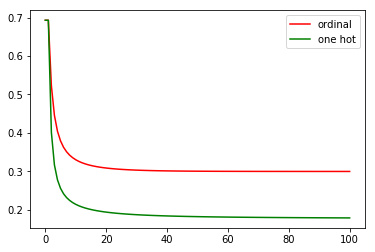

In [3]:

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
X_corona_pays = encoder.fit_transform(X_corona[:, 0].reshape(len(X_corona), 1))
X_corona_ordinal = np.concatenate((X_corona_pays, X_corona[:, 1].reshape((len(X_corona), 1))), axis=1)
X_corona_ordinal[:3, :]



from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
X_corona_pays = encoder.fit_transform(X_corona[:, 0].reshape(len(X_corona), 1))
X_corona_onehot = np.concatenate((X_corona_pays, X_corona[:, 1].reshape((len(X_corona), 1))), axis=1)
X_corona_onehot[:10, :]


msk = np.random.rand(len(X_corona)) < 0.8 

Y_corona_train = np.array(Y_corona[msk], dtype=np.float32)
Y_corona_test = np.array(Y_corona[~msk], dtype=np.float32)

X_corona_ordinal_train = np.array(X_corona_ordinal[msk, :], dtype=np.float32)
X_corona_ordinal_test = np.array(X_corona_ordinal[~msk, :], dtype=np.float32)

X_corona_onehot_train = np.array(X_corona_onehot[msk, :], dtype=np.float32)
X_corona_onehot_test = np.array(X_corona_onehot[~msk, :], dtype=np.float32)



reg_corona_ordinal = RegLogistique()
reg_corona_onehot = RegLogistique()


reg_corona_ordinal.entrainer(X_corona_ordinal_train, Y_corona_train)
reg_corona_onehot.entrainer(X_corona_onehot_train, Y_corona_train)


#Affichage des évolutions des couts 
plt.plot(reg_corona_ordinal.couts, color="red", label="ordinal")
plt.plot(reg_corona_onehot.couts, color="green", label="one hot")
plt.legend()
plt.show()


In [4]:
#test
H_corona_ordinal_test = reg_corona_ordinal.predire(X_corona_ordinal_test, prob=False)
H_corona_onehot_test = reg_corona_onehot.predire(X_corona_onehot_test, prob=False)

# Afficher la somme des 1 pour chaque 
H_corona_ordinal_test.sum(), H_corona_onehot_test.sum()


def calculerTP(Y_reel, Y_predit): 
    return (Y_reel * Y_predit).sum()

def calculerFN(Y_reel, Y_predit): 
    return (Y_reel * (1-Y_predit)).sum()

def calculerFP(Y_reel, Y_predit): 
    return ((1-Y_reel) * Y_predit).sum()

def calculerTN(Y_reel, Y_predit): 
    return ((1-Y_reel) * (1-Y_predit)).sum()

TP_corona_ordinal = calculerTP(Y_corona_test, H_corona_ordinal_test)
FN_corona_ordinal = calculerFN(Y_corona_test, H_corona_ordinal_test)
FP_corona_ordinal = calculerFP(Y_corona_test, H_corona_ordinal_test)
TN_corona_ordinal = calculerTN(Y_corona_test, H_corona_ordinal_test)


TP_corona_onehot = calculerTP(Y_corona_test, H_corona_onehot_test)
FN_corona_onehot = calculerFN(Y_corona_test, H_corona_onehot_test)
FP_corona_onehot = calculerFP(Y_corona_test, H_corona_onehot_test)
TN_corona_onehot = calculerTN(Y_corona_test, H_corona_onehot_test)


TN_corona_ordinal, FP_corona_ordinal, FN_corona_ordinal, TP_corona_ordinal
TN_corona_onehot, FP_corona_onehot, FN_corona_onehot, TP_corona_onehot


def rappel(TN, FP, FN, TP): 
    return TP/(TP + FN)

def precision(TN, FP, FN, TP): 
    return TP/(TP + FP)


R_corona_ordianl = rappel(TN_corona_ordinal, FP_corona_ordinal, FN_corona_ordinal, TP_corona_ordinal)
R_corona_onehot = rappel(TN_corona_onehot, FP_corona_onehot, FN_corona_onehot, TP_corona_onehot)


P_corona_ordianl = precision(TN_corona_ordinal, FP_corona_ordinal, FN_corona_ordinal, TP_corona_ordinal)
P_corona_onehot = precision(TN_corona_onehot, FP_corona_onehot, FN_corona_onehot, TP_corona_onehot)

R_corona_ordianl, R_corona_onehot
P_corona_ordianl, P_corona_onehot

(0.8888888888888888, 1.0)